# Thermal Neural Networks (Pytorch example)

This jupyter notebook showcases how to utilize a [thermal neural network (TNN)](https://www.sciencedirect.com/science/article/pii/S0952197622005279) on an exemplary data set with the [Pytorch](https://pytorch.org/) framework.

This example is concise for the sake of comprehensibility, that is, no cross-validation with a validation set is conducted, e.g., for early stopping, no learning rate scheduling, no repeated experiments with different random number generator seeds, etc.

Feel free to build and expand your training pipeline on top of this example.

The data set can be downloaded from [Kaggle](https://www.kaggle.com/wkirgsn/electric-motor-temperature).
It should be placed in `data/input/`.

In [4]:
import numpy as np
import pandas as pd
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim
from torch.nn import Parameter as TorchParam
from torch import Tensor
from typing import List, Tuple

## Data setup

In [5]:
path_to_csv='data/input/measures_v2.csv'
data = pd.read_csv(path_to_csv)
target_cols = ['pm', 'stator_yoke', 'stator_tooth', 'stator_winding']

temperature_cols = target_cols + ['ambient', 'coolant']
test_profiles = [60, 62, 74]
train_profiles = [p for p in data.profile_id.unique() if p not in test_profiles]
profile_sizes = data.groupby('profile_id').agg('size')

# normalize
non_temperature_cols = [c for c in data if c not in temperature_cols + ['profile_id']]
data.loc[:, temperature_cols] /= 100 # deg C
data.loc[:, non_temperature_cols] /= data.loc[:, non_temperature_cols].abs().max(axis=0)

# extra feats (FE)
if {'i_d', 'i_q', 'u_d', 'u_q'}.issubset(set(data.columns.tolist())):
    extra_feats = {'i_s': lambda x: np.sqrt((x['i_d']**2 + x['i_q']**2) ), 
                   'u_s': lambda x: np.sqrt((x['u_d']**2 + x['u_q']**2))}
data = data.assign(**extra_feats)
input_cols = [c for c in data.columns if c not in target_cols]
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
# overwrite. We recommend CPU over GPU here, as that runs faster with pytorch on this data set
device = torch.device('cpu')

In [6]:
# Rearrange features
input_cols = [c for c in data.columns if c not in target_cols]
data = data.loc[:, input_cols + target_cols]

def generate_tensor(profiles_list):
    tensor = np.full((profile_sizes[profiles_list].max(), len(profiles_list), data.shape[1] - 1), np.nan)
    for i, (pid, df) in enumerate(data.loc[data.profile_id.isin(profiles_list), :].groupby('profile_id')):
        assert pid in profiles_list, f"PID is not in {profiles_list}!"
        tensor[:len(df), i,  :] = df.drop(columns='profile_id').to_numpy()
    sample_weights = 1 - np.isnan(tensor[:, :, 0])
    tensor = np.nan_to_num(tensor).astype(np.float32)
    tensor = torch.from_numpy(tensor).to(device)
    sample_weights = torch.from_numpy(sample_weights).to(device)
    return tensor, sample_weights

train_tensor, train_sample_weights = generate_tensor(train_profiles)
test_tensor, test_sample_weights = generate_tensor(test_profiles)

## Model declaration

In [7]:
class RecursiveShell(nn.Module):
    def __init__(self, cell, *cell_args):
        super().__init__()
        self.cell = cell(*cell_args)

    def forward(self, input: Tensor, state: Tensor) -> Tuple[Tensor,Tensor]:
        inputs = input.unbind(0)
        outputs = torch.jit.annotate(List[Tensor], [])
        for i in range(len(inputs)):
            out, state = self.cell(inputs[i], state)
            outputs += [out]
        return torch.stack(outputs), state

class TNNCell(nn.Module):
    def __init__(self):
        super().__init__()
        self.sample_time = 0.5  # in s
        self.output_size = len(target_cols)
        self.caps = TorchParam(torch.Tensor(self.output_size).to(device))
        nn.init.normal_(self.caps, mean=-3, std=0.5)
        n_temps = len(temperature_cols)
        n_conds = int(0.5 * n_temps * (n_temps - 1))
        self.conductance_net = nn.Sequential(nn.Linear(len(input_cols), n_conds), nn.Sigmoid())
        # populate adjacency matrix
        self.adj_mat = np.zeros((n_temps, n_temps), dtype=int)
        adj_idx_arr = np.ones_like(self.adj_mat)
        triu_idx = np.triu_indices(n_temps, 1)
        adj_idx_arr = adj_idx_arr[triu_idx].ravel()
        self.adj_mat[triu_idx] = np.cumsum(adj_idx_arr) - 1
        self.adj_mat += self.adj_mat.T
        self.adj_mat = torch.from_numpy(self.adj_mat)
        self.n_temps = n_temps
        
        self.ploss = nn.Sequential(nn.Linear(len(input_cols), 16),
                                    nn.Tanh(),
                                    nn.Linear(16, self.output_size),
                                   )
        
        self.temp_idcs = [i for i, x in enumerate(input_cols) if x in temperature_cols]
        self.nontemp_idcs = [i for i, x in enumerate(input_cols) if x not in temperature_cols + ['profile_id']]
        
        # optimized indexing (faster computation)
        self.temps_indexer = np.array([j for i in range(self.output_size) for j in range(n_temps) if j != i ]).reshape(-1, n_temps-1)
        self.adj_mat_indexed = self.adj_mat[np.repeat(np.arange(self.output_size), n_temps-1), self.temps_indexer.ravel()].reshape(self.output_size, -1).tolist()
        self.temps_indexer = self.temps_indexer.tolist()
    
    def forward(self, inp: Tensor, hidden: Tensor) -> Tuple[Tensor, Tensor]:        
        prev_out = hidden
        temps = torch.cat([prev_out, inp[:, self.temp_idcs]], dim=1)
        conducts = self.conductance_net(inp)
        power_loss = torch.abs(self.ploss(inp))
        temp_diffs = torch.sum((temps[:, self.temps_indexer] - prev_out.unsqueeze(-1)) * conducts[:, self.adj_mat_indexed], dim=-1)
        out = prev_out + self.sample_time * (10**self.caps) * (temp_diffs + power_loss)
        return prev_out, torch.clip(out, -1, 5)


## Training

In [ ]:
model = torch.jit.script(RecursiveShell(TNNCell)).to(device)
loss_func = nn.MSELoss(reduction="none")
opt = optim.Adam(model.parameters(), lr=1e-3)
n_epochs = 100
tbptt_size = 1024

n_batches = np.ceil(train_tensor.shape[0] / tbptt_size).astype(int)
with tqdm(desc="Training", total=n_epochs) as pbar:
    for epoch in range(n_epochs):
        hidden = train_tensor[0, :,  -len(target_cols):]
        
        for i in range(n_batches):
            model.zero_grad()
            output, hidden = model(train_tensor[i*tbptt_size:(i+1)*tbptt_size, :, :len(input_cols)], hidden.detach())
            loss = loss_func(output, train_tensor[i*tbptt_size:(i+1)*tbptt_size, :, -len(target_cols):])
            # sample_weighting
            loss = (loss * train_sample_weights[i*tbptt_size:(i+1)*tbptt_size, :, None] / train_sample_weights[i*tbptt_size:(i+1)*tbptt_size, :].sum()).sum().mean()
            loss.backward()
            opt.step()
            
        pbar.update()
        pbar.set_postfix_str(f'loss: {loss.item():.3f}')


## Testing

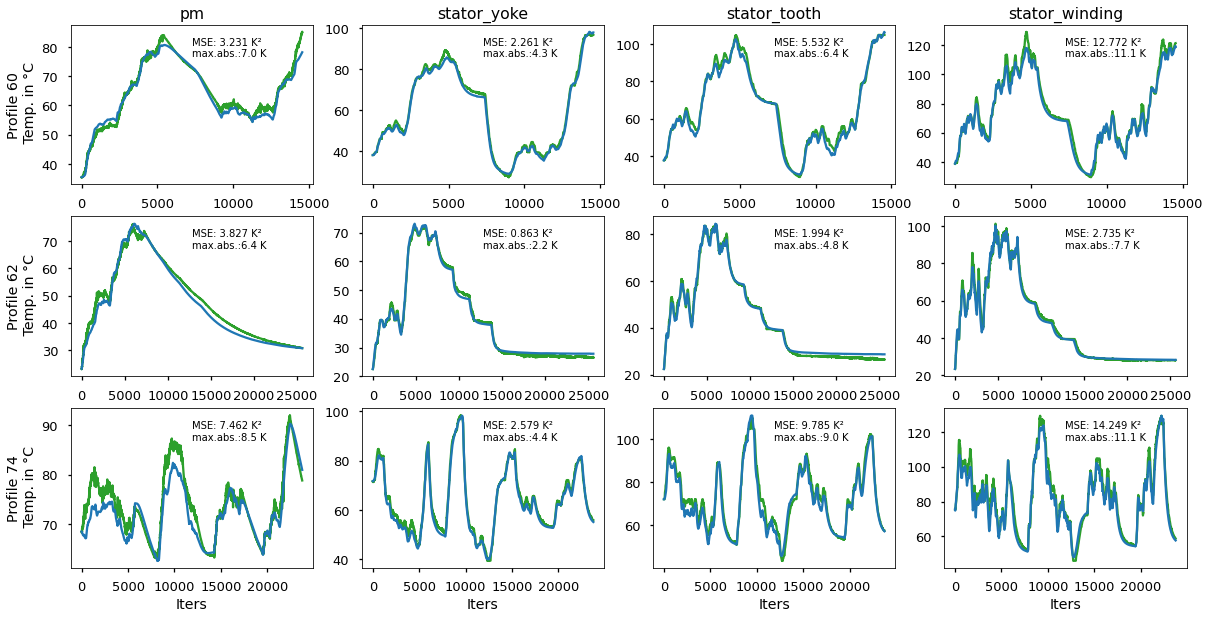

In [8]:
with torch.no_grad():
    pred, hidden = model(test_tensor[:, :, :len(input_cols)], test_tensor[0, :,  -len(target_cols):])
    pred = pred.cpu().detach().numpy() * 100  # denormalize

fig, axes = plt.subplots(len(test_profiles), len(target_cols), figsize=(20, 10))
for i, (pid, y_test) in enumerate(data.loc[data.profile_id.isin(test_profiles), target_cols + ['profile_id']].groupby('profile_id')):
    y_test *= 100
    profile_pred = pred[:len(y_test), i, :]
    for j, col in enumerate(target_cols):
        ax = axes[i, j]
        ax.plot(y_test.loc[:, col].reset_index(drop=True), color='tab:green')
        ax.plot(profile_pred[:, j], color='tab:blue')
        ax.text(x=0.5, y=0.8, 
                s=f'MSE: {((profile_pred[:, j] - y_test.loc[:, col])**2).sum() / len(profile_pred):.3f} K²\nmax.abs.:{(profile_pred[:, j]-y_test.loc[:, col]).abs().max():.1f} K',
                transform=ax.transAxes)
        if j == 0:
            ax.set_ylabel(f'Profile {pid}\n Temp. in °C')
        if i == len(test_profiles) - 1:
            ax.set_xlabel(f'Iters')
        elif i == 0:
            ax.set_title(col)